In [20]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from gmm_dataset import *
from util_hmm_variational_gibbs import *
from util_plots import *
from scipy.stats import invwishart, dirichlet
from torch.distributions.dirichlet import Dirichlet
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [21]:
T = 30
K = 3
D = 2
num_particles_rws = 50
mcmc_steps = 2
num_particles_smc = 30
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = 2 * K
# training parameters
NUM_SAMPLES = 1
# BATCH_SIZE = 100
NUM_EPOCHS = 80
LEARNING_RATE = 1e-3
CUDA = False

RESTORE = False

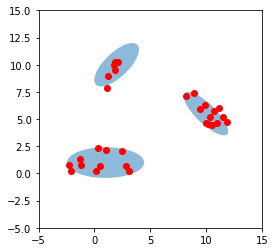

In [22]:
Xs, mu_true, cov_true, Zs_true, Pi_true, A_true = sampling_hmm(T, K, D)
plot_samples(Xs.data.numpy(), mu_true.data.numpy(), cov_true.data.numpy())
Y = Xs

In [23]:
## return samples in order to compute the weights and 
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, num_particles):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        latents_dirs_norm = latents_dirs / latents_dirs.sum() * (T-1)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs_norm[k]).sample()
        return latents_dirs_norm, A_samples

In [24]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer

alpha_init_0, alpha_trans_0, m_0, beta_0, nu_0, W_0 = pirors(Y, T, D, K)
enc, optimizer = initialize()
## initialization
# cov_ks = torch.zeros((K, D, D))
# mu_ks = torch.zeros((K, D))
# for k in range(K):
# ## sample mu_k and Sigma_k randomly
#     cov_ks[k] = torch.from_numpy(invwishart.rvs(df=nu_0, scale=W_0.data.numpy())).float()
#     mu_ks[k] = MultivariateNormal(loc=m_0, covariance_matrix=cov_ks[k] / beta_0).sample()
# Pi = Dirichlet(alpha_init_0).sample()
# A_samples = initial_trans(alpha_trans_0, K)

In [ ]:
KLs = []
KL_ests = []
log_p_conds = []
log_qs = []
ESSs = []

Pi = Pi_true
mu_ks = mu_true
cov_ks = cov_true
# Z_ret = Zs_true
# Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    log_weights_rws = torch.zeros(num_particles_rws)
    log_qs = torch.zeros(num_particles_rws)
    kl = 0.0
    for l in range(num_particles_rws):
#         A_samples = initial_trans(alpha_trans_0, K)
        A_samples = A_true
        Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
        Z_ret = resampling_smc(Zs, log_weights)
        log_weight_rws = log_normalizer
        Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
        for m in range(mcmc_steps):
            A_prev = A_samples
            latents_dirs, A_samples = enc(Z_ret_pairwise, 1)
            log_p_joint_curr = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K).detach().item()
#             log_p_joint_prev = log_joint(alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, Z_ret, Pi, A_prev, mu_ks, cov_ks, Y, T, D, K).detach().item() 
            log_p_smc = log_joint_smc(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K)
            log_q_curr = log_q_hmm(latents_dirs, A_samples, K, num_particles=1).detach()
            log_q_prev = log_q_hmm(latents_dirs, A_prev, K,num_particles=1).detach()
            
            Zs, log_weights, log_normalizer = csmc_hmm(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
            Z_ret = resampling_smc(Zs, log_weights)
            Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)

            log_weight_rws += log_p_joint_curr - log_p_smc - log_q_curr + log_q_prev + log_normalizer
              
        log_weights_rws[l] = log_weight_rws.detach()     

  
        alpha_trans_hat = alpha_trans_0 + pairwise(Z_ret, T).sum(0)
        kl += kl_dirichlets(alpha_trans_0, latents_dirs, Z_ret, T, K)      
        log_qs[l] = log_q_hmm(latents_dirs, A_samples, K, num_particles=1)   
    kl /= num_particles_rws
        
    log_weights_rws = log_weights_rws - log_sum_exp(log_weights_rws)
    weights_rws = torch.exp(log_weights_rws)
    ess = (1. / (weights_rws ** 2 ).sum()).item()
    loss_infer = - torch.mul(weights_rws, log_qs).sum()
#     kl_est = torch.mul(weights_rws, log_p_conds - log_qs).sum().detach().item()
    loss_infer.backward()
    KLs.append(kl.item())
#     KL_ests.append(kl_est)
    ESSs.append(ess)
    optimizer.step()
#     A_samples = A_samples.detach()
    time_end = time.time()
    print('epoch : %d, KL : %f, loss_infer : %f (%ds)' % (epoch, kl, loss_infer, time_end - time_start))

epoch : 0, KL : 5.267386, loss_infer : -2.914855 (43s)
epoch : 1, KL : 5.004850, loss_infer : -3.964167 (43s)
epoch : 2, KL : 4.718925, loss_infer : -3.619146 (43s)
epoch : 3, KL : 4.354506, loss_infer : -2.086236 (43s)
epoch : 4, KL : 4.120155, loss_infer : -1.522557 (43s)
epoch : 5, KL : 3.956549, loss_infer : -1.393750 (43s)
epoch : 6, KL : 3.716486, loss_infer : -3.115009 (43s)
epoch : 7, KL : 3.379955, loss_infer : -3.760072 (43s)
epoch : 8, KL : 3.194972, loss_infer : -2.877061 (43s)
epoch : 9, KL : 2.968087, loss_infer : -4.748078 (43s)
epoch : 10, KL : 2.739328, loss_infer : -4.628841 (43s)
epoch : 11, KL : 2.517862, loss_infer : -3.923955 (43s)
epoch : 12, KL : 2.348000, loss_infer : -2.392671 (43s)
epoch : 13, KL : 2.029716, loss_infer : -4.590868 (43s)
epoch : 14, KL : 1.853231, loss_infer : -2.317251 (43s)
epoch : 15, KL : 1.685183, loss_infer : -3.781603 (43s)
epoch : 16, KL : 1.521153, loss_infer : -4.249825 (43s)
epoch : 17, KL : 1.382743, loss_infer : -4.557587 (43s)
ep

In [7]:
# plot_kl_est(np.array(KLs))

In [8]:
alpha_trans_0 + pairwise(Zs_true, T).sum(0)

tensor([[3.3333, 1.3333, 1.3333],
        [1.3333, 1.3333, 1.3333],
        [0.3333, 1.3333, 0.3333]])

In [14]:
learned_dicichlet_post = latents_dirs
true_dirichlet_post = alpha_trans_0 + pairwise(Zs_true, T).sum(0)
print('variational : ')
print(learned_dicichlet_post)
print('conjugate posterior :')
print(true_dirichlet_post)

variational : 
tensor([[1.9489, 0.4415, 0.7086],
        [1.0214, 1.3750, 1.2484],
        [0.3909, 1.4219, 0.4436]], grad_fn=<MulBackward>)
conjugate posterior :
tensor([[3.3333, 1.3333, 1.3333],
        [1.3333, 1.3333, 1.3333],
        [0.3333, 1.3333, 0.3333]])


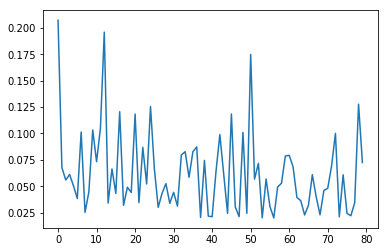

In [10]:
plt.plot(np.array(ESSs) / num_particles_rws)